<hr style="border-top-width:4px; border-top-color: #00df;">

# Analysis of Covid-19 papers

* Emerson
* Mojtaba Roshana
* Luca 
* Roya Joulaei

<hr style="border-top-width:4px; border-top-color: #00df;">


# Introduction
This distributed computing project will be focused on the analysis of 1000 papers about COVID-19, SARS-CoV-2, and related coronaviruses. The dataset is a sub-sample of 1000 items taken from the original dataset that is composed of more than 75000 (and still growing) papers. This dataset is a part of real-world research on COVID-19 named COVID-19 Open Research Dataset Challenge (CORD-19). The research and related chal- lenges are available on the dedicated page on Kaggle: https://www.kaggle.com/allen- institute-for-ai/CORD-19-research-challenge


In [4]:
from dask.distributed import Client, SSHCluster
from dask import delayed
import dask.bag as db
import dask.dataframe as ddf
from dask.array import histogram
import hvplot.dask

import csv
import pandas as pd
import functools

import os
import json
import time

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk

from collections import Counter
from operator import add
from operator import itemgetter

import numpy as np
import matplotlib.pyplot as plt
import bokeh.palettes as palette

#import pandas as pd

from operator import itemgetter
import io
import numpy as np



* There are three vitual machines: 

In [97]:
machine1 = '10.67.22.93'
machine2 = '10.67.22.77'
machine3 = '10.67.22.134'

* Define the Client with SSHCluster:

In [114]:
cluster = SSHCluster([machine2, machine1, machine3])
client = Client(cluster)


2022-07-11 16:07:58,227 - distributed.deploy.ssh - INFO - /usr/local/lib/python3.8/dist-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
2022-07-11 16:07:58,229 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2022-07-11 16:07:58,230 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 37037 instead
2022-07-11 16:07:58,232 - distributed.deploy.ssh - INFO - warnings.warn(
2022-07-11 16:07:58,233 - distributed.deploy.ssh - INFO - 2022-07-11 16:07:58,224 - distributed.scheduler - INFO - State start
2022-07-11 16:07:58,236 - distributed.deploy.ssh - INFO - 2022-07-11 16:07:58,231 - distributed.scheduler - INFO - Clear task state
2022-07-11 16:07:58,237 - distributed.deploy.ssh - INFO - 2022-07-11 16:07:58,231 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.77:34783
2022-07-11 16:07:59,992 - distributed.deploy.ssh - INFO - 2022-07-11 16:07:59,990 - distributed.nanny - INFO -         Start Nanny at: 'tcp:/

* As we can see, machine2 is the sceduler and two others are the workers
* We have 15.54 GiB RAM total memory

In [96]:
client

<Client: 'tcp://10.67.22.77:41743' processes=2 threads=8, memory=15.54 GiB>

# Loading the data  

* We make a 200Gib volume and download the data inside

* Then make a 30Gib volume and attach it to machine2: /mnt

* We make a shared space in that Volume by nfs : /mnt/nfs_share/

* And collect 1000 of data  inside shared space


Our RAW data are in json format multiple line therefore we convert them to single line json to make it readable:

In [ ]:
'''
def one_lined(filename):
    f = open(filename)
    obj = json.load(f)
    flatten_str = json.dumps(obj)  #this coommaand convert a dictionary into a string
    jsonFile=open("./new/"+"new_"+filename,"w")
    jsonFile.write(flatten_str)
    jsonFile.close
#l=os.listdir('/mnt/nfs_share/test')
#cd /mnt/nfs_share/test

for i in l:
    if (i != 'new'):
        print(i)
        f = open(i)
        obj = json.load(f)
        flatten_str = json.dumps(obj)
        jsonFile=open("./new/"+"new_"+i,"w")
        jsonFile.write(flatten_str)
        jsonFile.close
'''

## Make a dask-bag
Take all the single-line json files inside a bag (lines)

In [8]:
filename = '/mnt/nfs_share/test/new/*.json'
bag = db.read_text(filename)
js = bag.map(json.loads).repartition(3)

#json.loads method converts a valid JSON string into a Python
#Dictionary
                        

In [9]:
#js.take(1)

* ### But we need only the body text part

In [26]:
js.pluck("body_text").take(1)

([{'text': 'SARS-CoV-2 pneumonia manifests as acute respiratory failure, which most often requires oxygen supplementation. In severely affected patients, the need for oxygen is sometimes so great that it can lead to invasive mechanical ventilation, a procedure that is associated with a high mortality rate. [1] At the beginning of the pandemic, the indications for intubation of patients with COVID-19 were broad. [1] However, as more experience was gained, practitioners began to use high-flow nasal oxygen therapy as an alternative to too early intubation. This method provides humidified and heated oxygen with a FiO2 of up to 100% and a flow rate of up to 80L/min. This would decrease the work of breathing, decrease dead space, improve mucociliary clearance and give a PEEP effect of 2 to 7 mmHg. [2] This technique of high flow nasal oxygen therapy was at the beginning of the pandemic limited to a flow of 30L/min [3] because the learned societies feared a high contamination of the nursing s

# 1.Word counter distributed algorithm:




## Map phase

* For each document Di, produce the set of intermediate pairs (w, cp(w)), one for each word w ∈ Di, where cp(w) is the number of occurrences of w in Di. E.g.: (′hello′,3)


### We collect the text part ("body_text") of papers and merge them togethere

In [17]:
def merge_json(data):
    all_text=''
    for t in data:
        all_text+=t['text'] # only text part of budy text
    return all_text

texts = js.pluck("body_text").map(merge_json) # the bag with only text part of data
texts.take(1)


("SARS-CoV-2 pneumonia manifests as acute respiratory failure, which most often requires oxygen supplementation. In severely affected patients, the need for oxygen is sometimes so great that it can lead to invasive mechanical ventilation, a procedure that is associated with a high mortality rate. [1] At the beginning of the pandemic, the indications for intubation of patients with COVID-19 were broad. [1] However, as more experience was gained, practitioners began to use high-flow nasal oxygen therapy as an alternative to too early intubation. This method provides humidified and heated oxygen with a FiO2 of up to 100% and a flow rate of up to 80L/min. This would decrease the work of breathing, decrease dead space, improve mucociliary clearance and give a PEEP effect of 2 to 7 mmHg. [2] This technique of high flow nasal oxygen therapy was at the beginning of the pandemic limited to a flow of 30L/min [3] because the learned societies feared a high contamination of the nursing staff throu

* We split the words
* remove the stop words which does not add any meaning ( i.e have,has,is,or,and )


In [18]:
#s=time.time()
def cleaner(text):

    stop_words = stopwords.words('english')
    text_tokens=word_tokenize(text)

    tokens_without_sw=[word.lower() for word in text_tokens if not word.lower() in stop_words and word.isalpha()]
    return tokens_without_sw

text_clean = texts.map(cleaner)
text_clean.take(1)[0][:15]
#e=time.time()
#e-s
#3 sex

['pneumonia',
 'manifests',
 'acute',
 'respiratory',
 'failure',
 'often',
 'requires',
 'oxygen',
 'supplementation',
 'severely',
 'affected',
 'patients',
 'need',
 'oxygen',
 'sometimes']

* ## Count each unique word and its frequency

In [32]:
# convert list to list of directories
# where the unique words and their frequency is stored

def count(text):
    counts = dict(zip(Counter(text).keys(), Counter(text).values()))
    words_counted = [{"word":x , "frequency": y} for x,y in counts.items()]
    return words_counted

words = text_clean.map(count)
words.take(1)

([{'word': 'pneumonia', 'frequency': 2},
  {'word': 'manifests', 'frequency': 1},
  {'word': 'acute', 'frequency': 4},
  {'word': 'respiratory', 'frequency': 5},
  {'word': 'failure', 'frequency': 4},
  {'word': 'often', 'frequency': 1},
  {'word': 'requires', 'frequency': 1},
  {'word': 'oxygen', 'frequency': 17},
  {'word': 'supplementation', 'frequency': 2},
  {'word': 'severely', 'frequency': 1},
  {'word': 'affected', 'frequency': 1},
  {'word': 'patients', 'frequency': 23},
  {'word': 'need', 'frequency': 1},
  {'word': 'sometimes', 'frequency': 1},
  {'word': 'great', 'frequency': 1},
  {'word': 'lead', 'frequency': 1},
  {'word': 'invasive', 'frequency': 3},
  {'word': 'mechanical', 'frequency': 7},
  {'word': 'ventilation', 'frequency': 10},
  {'word': 'procedure', 'frequency': 1},
  {'word': 'associated', 'frequency': 2},
  {'word': 'high', 'frequency': 8},
  {'word': 'mortality', 'frequency': 6},
  {'word': 'rate', 'frequency': 6},
  {'word': 'beginning', 'frequency': 2},
  

## Reduce phase

* For each word w, gather all the previous pairs (w, cp(w)) and return the final pair (w,c(w)) where c(w) is the number of occurrences of w for all the Documents.


In [34]:
def sumation(total, x):
    return total+x['frequency']

# using flatten to un-fold the dictionary into a list-like object
# using foldby to sum all unique words 

All_counts = words.flatten().foldby('word', binop=sumation,initial=0,combine=add,combine_initial=0).compute()

In [73]:
# sorting
All_counts_sorted = sorted(All_counts, key=itemgetter(1), reverse=True)
All_counts_sorted[:10]

[('patients', 10046),
 ('et', 9532),
 ('study', 9386),
 ('data', 8821),
 ('also', 8188),
 ('may', 6599),
 ('using', 6307),
 ('used', 6175),
 ('health', 6062),
 ('cells', 5633)]

In [82]:
#All_counts_sorted=All_counts_sorted.pop(1)
#del All_counts_sorted[7]
#All_counts_sorted

# Plot for most repeated words in papers

In [84]:
freq = [All_counts_sorted[i][1] for i in range(0,len(All_counts_sorted))]
word = [All_counts_sorted[i][0] for i in range(0,len(All_counts_sorted))]

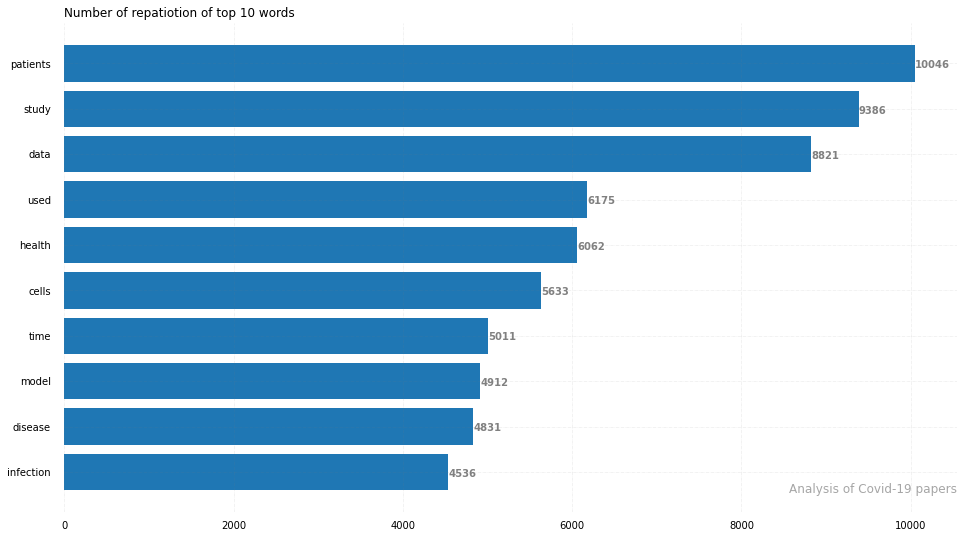

In [85]:
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(word[:10], freq[:10])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
            fontsize = 10, fontweight ='bold',
            color ='gray')
ax.set_title('Number of repatiotion of top 10 words',
            loc ='left', )
fig.text(0.9, 0.15, 'Analysis of Covid-19 papers', fontsize = 12,
        color ='grey', ha ='right', va ='bottom',
        alpha = 0.7)
plt.show()

## 2.Which are the worst and best-represented countries in the research?
In this part, you have to take the documents and convert them into a usable DataFrame data structure to figure out the countries that are most and less active in the research. To do this you can use the country of the authors. Do the same for the universities (affiliations).
Even in this case do multiple runs by changing the number of partitions and workers and then describe the behavior of the timings.


In [86]:
#let's create the function to extract the needed features
def feat(record):
    name=surname=university=country=''
    
    name = record['first']
    surname = record['last']
    
    if record['affiliation'] == {}:
        university = 'Not given'
        country = 'Not given'
    
    else: #affiliation not void
        if 'institution' in record['affiliation'].keys() and record['affiliation']['institution'] != '': university = record['affiliation']['institution']
        else: university = 'Not given'
        
    if 'location' in record['affiliation'].keys() and 'country' in record['affiliation']['location'].keys() and record['affiliation']['location']['country'] != '':
        country = record['affiliation']['location']['country']
    else: country = 'Not given'
    
    #country='gatto'
    return {
        'name':       name,
        'surname':    surname, 
        'university': university,
        'country':    country,
    }
        
       

In [87]:
authors = js.pluck('metadata').pluck('authors').flatten()
authors_DataFrame = authors.map(feat).to_dataframe()
authors_DataFrame.head()

,name,surname,university,country
0,Rajae,Alkouh,Not given,Not given
1,Abdelilah,Rhalete,VI University Hospital,Morocco
2,Merbouh,Manal,VI University Hospital,Morocco
3,Aidouni,Ghizlane,Not given,Not given
4,Berrichi,Samia,VI University Hospital,Morocco


In [121]:
authors_DataFrame.university.value_counts().head(2) #from here it is possible to make an histogram
authors.take(2)

({'first': 'Rajae',
  'middle': [],
  'last': 'Alkouh',
  'suffix': '',
  'affiliation': {},
  'email': 'alkouhrajae1993@gmail.com'},
 {'first': 'Abdelilah',
  'middle': ['El'],
  'last': 'Rhalete',
  'suffix': '',
  'affiliation': {'laboratory': '',
   'institution': 'VI University Hospital',
   'location': {'settlement': 'Oujda',
    'region': 'Mohammed',
    'country': 'Morocco'}},
  'email': 'elrhaleteabdelilah@yahoo.fr'})

In [140]:
countries = authors_DataFrame.country.value_counts()

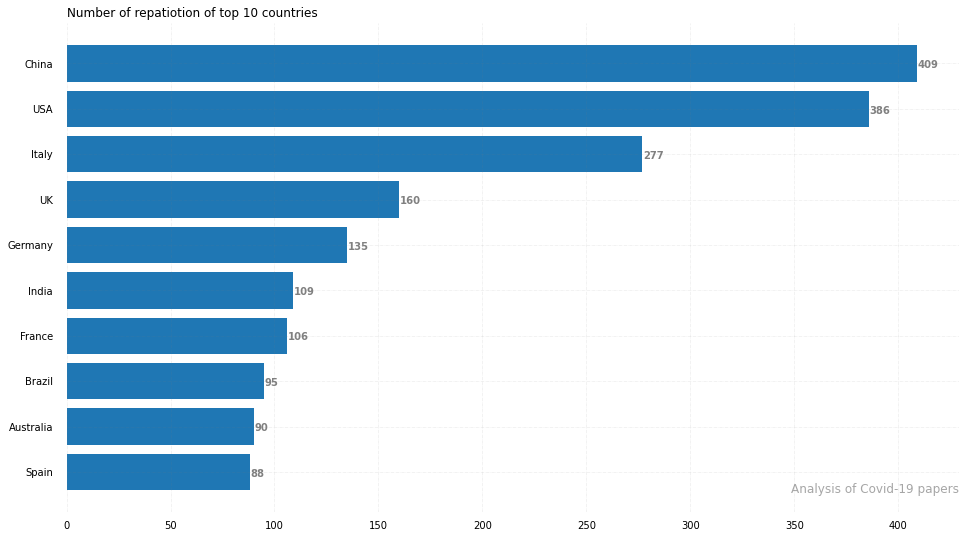

In [147]:
n=10
data = countries.nlargest(n+1).compute()
data = data[data.axes[0]!='Not given']
height = [data[i] for i in range(0,n)]
bars = [data.axes[0][i] for i in range(0,n)]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(bars[:10], height[:10])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
            fontsize = 10, fontweight ='bold',
            color ='gray')
ax.set_title('Number of repatiotion of top 10 countries',
            loc ='left', )
fig.text(0.9, 0.15, 'Analysis of Covid-19 papers', fontsize = 12,
        color ='grey', ha ='right', va ='bottom',
        alpha = 0.7)
plt.show()

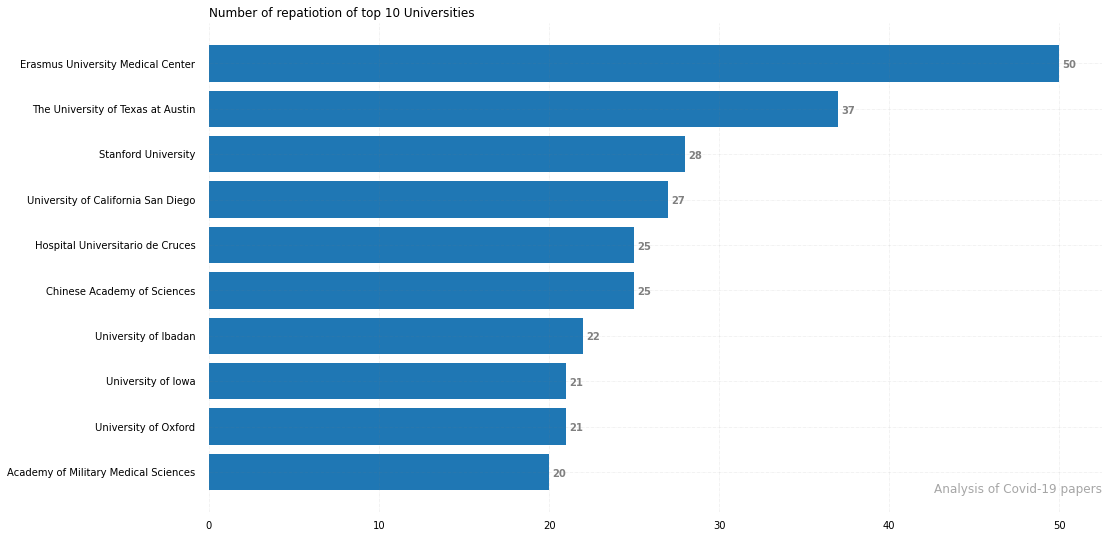

In [146]:
univs = authors_DataFrame.university.value_counts()

n=10
data = univs.nlargest(n+1).compute()
data = data[data.axes[0]!='Not given']
height = [data[i] for i in range(0,n)]
bars = [data.axes[0][i] for i in range(0,n)]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(bars[:10], height[:10])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
            fontsize = 10, fontweight ='bold',
            color ='gray')
ax.set_title('Number of repatiotion of top 10 Universities',
            loc ='left', )
fig.text(0.9, 0.15, 'Analysis of Covid-19 papers', fontsize = 12,
        color ='grey', ha ='right', va ='bottom',
        alpha = 0.7)
plt.show()

* # Chek computation time with different partitions


 Even in this case do multiple runs by changing the number of partitions and workers and then describe the behavior of the timings.

* ## With two workers:

In [93]:
def timing_part1(partitions):

    i = time.time() 
    filename = '/mnt/nfs_share/test/new/*.json'
    bag = db.read_text(filename)

    #process
    All_counts = (bag.map(json.loads).repartition(partitions).pluck('body_text').map(merge_json).map(cleaner)
                  .map(count).flatten().foldby('word', binop=sumation, initial=0, combine=add, combine_initial=0)
                  .compute())
    All_counts_sorted = sorted(All_counts, key=itemgetter(1), reverse=True)
    
    f = time.time()
    
    
    return (f-i)

In [95]:
partitions=[1,2,4,8,12]
for i in partitions:
    print('for partitions=',i,'timing is :', timing_part1(i))

for partitions= 1 timing is : 43.731369972229004
for partitions= 2 timing is : 43.6949143409729
for partitions= 4 timing is : 42.523178577423096
for partitions= 8 timing is : 40.644028186798096
for partitions= 12 timing is : 41.36608290672302


Text(0.5, 1.0, 'With two Worker for computuing most words used in papers')

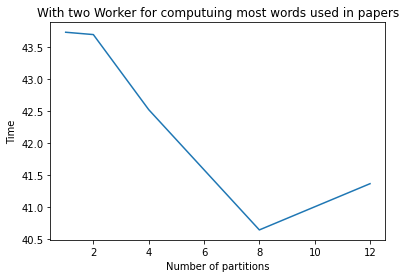

In [127]:
partitions=[1,2,4,8,12]
ts=[43.731369972229004,43.6949143409729,42.523178577423096,40.644028186798096,41.36608290672302]
plt.plot(partitions,ts)
plt.xlabel('Number of partitions')
plt.ylabel('Time')
plt.title('With two Worker for computuing most words used in papers')

In [101]:
# timing for part 2
def timing_countries(partitions):
    i = time.time() #start taking time
    auth_df = (bag.map(json.loads).repartition(partitions)
               .pluck('metadata').pluck('authors').flatten().map(feat).to_dataframe())
    countries = authors_DataFrame.country.value_counts().nlargest(10).compute()
    f = time.time()
    return f-i

In [104]:
partitions=[1,2,4,8,12,16]
for i in partitions:
    print('for partitions=',i,'timing is :', timing_countries(i))

for partitions= 1 timing is : 21.809123992919922
for partitions= 2 timing is : 15.338640451431274
for partitions= 4 timing is : 12.722925662994385
for partitions= 8 timing is : 11.696454763412476
for partitions= 12 timing is : 11.248386859893799
for partitions= 16 timing is : 10.814738750457764


* ## Reduce workers to only one worker:


Definitely it makes computation longer becuase we are reducing the resourses ( Total memory: 15.54 GiB --> 7.77 GiB) 

In [113]:
client.close() #close client
cluster.close() #close cluster

In [109]:
cluster = SSHCluster([machine2, machine1])
client = Client(cluster)

2022-07-11 16:02:00,540 - distributed.deploy.ssh - INFO - /usr/local/lib/python3.8/dist-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
2022-07-11 16:02:00,545 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2022-07-11 16:02:00,546 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 34499 instead
2022-07-11 16:02:00,547 - distributed.deploy.ssh - INFO - warnings.warn(
2022-07-11 16:02:00,548 - distributed.deploy.ssh - INFO - 2022-07-11 16:02:00,538 - distributed.scheduler - INFO - State start
2022-07-11 16:02:00,552 - distributed.deploy.ssh - INFO - 2022-07-11 16:02:00,541 - distributed.scheduler - INFO - Clear task state
2022-07-11 16:02:00,553 - distributed.deploy.ssh - INFO - 2022-07-11 16:02:00,542 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.77:40397
2022-07-11 16:02:03,636 - distributed.deploy.ssh - INFO - 2022-07-11 16:02:03,626 - distributed.nanny - INFO -         Start Nanny at: 'tcp:/

In [110]:
client

<Client: 'tcp://10.67.22.77:40397' processes=1 threads=4, memory=7.77 GiB>

In [112]:
partitions=[1,2,4,8,12,16]
for i in partitions:
    print('for partitions=',i,'timing is :', timing_countries(i))

for partitions= 1 timing is : 34.420822620391846
for partitions= 2 timing is : 26.454702138900757
for partitions= 4 timing is : 22.312560319900513
for partitions= 8 timing is : 20.23440670967102
for partitions= 12 timing is : 19.26630735397339
for partitions= 16 timing is : 19.428391218185425


Text(0.5, 1.0, 'Computuing most countries')

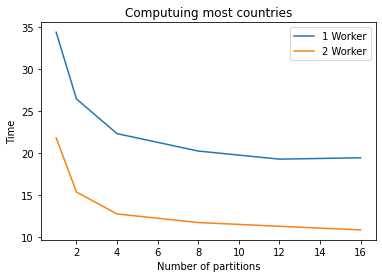

In [132]:
tsc=[21.809123992919922,15.338640451431274,12.722925662994385,11.696454763412476,11.248386859893799,10.814738750457764]
tss=[34.420822620391846,26.454702138900757,22.312560319900513,20.23440670967102,19.26630735397339,19.428391218185425]
plt.plot(partitions,tss,label='1 Worker')
plt.xlabel('Number of partitions')
plt.ylabel('Time')
plt.plot(partitions,tsc,label='2 Worker')
plt.legend()
plt.title('Computuing most countries')

# 3. Get the embedding for the title of the papers

In NLP a common technique for performing analysis over a set of texts is to transform the text into a set of vectors each one representing a word inside a document. At the end of the pre-processing the document will be transformed into a list of vectors or a matrix of n × m where n is the number of words in the document and m is the size of the vector that represents the word n.

In [12]:
model = ddf.read_table('/mnt/nfs_share/wiki.en.vec',
                      quoting=csv.QUOTE_NONE,
                      skiprows=1,
                      header=None, 
                      sep=' ',
                      blocksize='10MB')

In [13]:
model.head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,301
0,",",-0.023167,-0.004248,-0.105720,0.042783,-0.143160,-0.078954,0.078187,-0.194540,0.022303,...,-0.11558,0.044184,-0.023124,0.025860,-0.116530,0.010936,0.089398,-0.01590,0.148660,NaN
1,.,-0.111120,-0.001386,-0.177800,0.064508,-0.240370,0.031087,-0.030144,-0.368830,-0.043855,...,-0.21914,-0.042760,-0.136850,0.097470,-0.218180,-0.058233,0.063374,-0.12161,0.039339,NaN
2,the,-0.065334,-0.093031,-0.017571,0.200070,0.029521,-0.039920,-0.163280,-0.072946,0.089604,...,-0.21673,-0.037683,0.081860,-0.039891,-0.051334,-0.101650,0.166420,-0.13079,0.035397,NaN


In [14]:
model[model[0] == ','].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,301
0,",",-0.023167,-0.004248,-0.10572,0.042783,-0.14316,-0.078954,0.078187,-0.19454,0.022303,...,-0.11558,0.044184,-0.023124,0.02586,-0.11653,0.010936,0.089398,-0.0159,0.14866,NaN


In [15]:
def extract_id_title(record):
    ID = record['paper_id']
    title_tokens = word_tokenize(record['metadata']['title'])
    title = [word.lower() for word in title_tokens] #deleting punctuation marks could be a good idea.
    return{'ID': ID,
          'title': title}

In [16]:
titles = js.map(extract_id_title)

In [17]:
titles.take(2)

({'ID': '0021ebe4404bb7aea40f696a8261b6bd1d4a7f6b',
  'title': ['journal',
   'pre-proof',
   'high-flow',
   'nasal',
   'oxygen',
   'therapy',
   'decrease',
   'the',
   'risk',
   'of',
   'mortality',
   'and',
   'the',
   'use',
   'of',
   'invasive',
   'mechanical',
   'ventilation',
   'in',
   'patients',
   'with',
   'severe',
   'sars-cov-2',
   'pneumonia',
   '?',
   'a',
   'retrospective',
   'and',
   'comparative',
   'study',
   'of',
   '265',
   'cases',
   'high-flow',
   'nasal',
   'oxygen',
   'therapy',
   'decrease',
   'the',
   'risk',
   'of',
   'mortality',
   'and',
   'the',
   'use',
   'of',
   'invasive',
   'mechanical',
   'ventilation',
   'in',
   'patients',
   'with',
   'severe',
   'sars-cov-2',
   'pneumonia',
   '?',
   'alkouh',
   'rajae',
   'corresponding',
   'author',
   'merbouh',
   'manal',
   'guarantor',
   'authors']},
 {'ID': '009b5163b1d8dc61b76f424203ecdc3885234ada',
  'title': ['high',
   'level',
   'expression',
   'o

In [18]:
title_df = titles.to_dataframe()
title_df.head(4)

,ID,title
0,0021ebe4404bb7aea40f696a8261b6bd1d4a7f6b,"[journal, pre-proof, high-flow, nasal, oxygen,..."
1,009b5163b1d8dc61b76f424203ecdc3885234ada,"[high, level, expression, of, surface, glycopr..."
2,00a407540a8bdd6d7425bd8a561eb21d69682511,"[title, :, rapid, ai, development, cycle, for,..."
3,00de40db0c80064b049e3b90d4a6710bb2dfcbc8,"[modelling, the, covid-19, pandemic, in, conte..."


In [54]:
#now I want to find all the words in the titles

In [19]:
#I can use the previous functions
title_count = titles.pluck('title').map(count_words).flatten().foldby('word', binop=incr_amount,initial=0,combine=add,combine_initial=0).compute()

In [20]:
unique_words_title = [title_count[i][0] for i in range(0,len(title_count))]

In [57]:
len(unique_words_title) #I want to to use this to filter the model

4243

In [65]:
model[model[0] == ','].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,301
0,",",-0.023167,-0.004248,-0.10572,0.042783,-0.14316,-0.078954,0.078187,-0.19454,0.022303,...,-0.11558,0.044184,-0.023124,0.02586,-0.11653,0.010936,0.089398,-0.0159,0.14866,NaN


In [21]:
mask = model[0].isin(unique_words_title)#very slow, maybe there is a more efficient way.

In [75]:
len(mask)

SyntaxError: unexpected EOF while parsing (1150260447.py, line 1)

In [74]:
len(model)

2519370

In [78]:
mask.head(100)

0      True
1      True
2      True
3     False
4      True
      ...  
95     True
96    False
97     True
98     True
99     True
Name: 0, Length: 100, dtype: bool

In [22]:
filtered_model = model[mask]

In [27]:
filtered_model.head(3) 

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,301
0,",",-0.023167,-0.004248,-0.105720,0.042783,-0.143160,-0.078954,0.078187,-0.194540,0.022303,...,-0.11558,0.044184,-0.023124,0.025860,-0.116530,0.010936,0.089398,-0.01590,0.148660,NaN
1,.,-0.111120,-0.001386,-0.177800,0.064508,-0.240370,0.031087,-0.030144,-0.368830,-0.043855,...,-0.21914,-0.042760,-0.136850,0.097470,-0.218180,-0.058233,0.063374,-0.12161,0.039339,NaN
2,the,-0.065334,-0.093031,-0.017571,0.200070,0.029521,-0.039920,-0.163280,-0.072946,0.089604,...,-0.21673,-0.037683,0.081860,-0.039891,-0.051334,-0.101650,0.166420,-0.13079,0.035397,NaN


In [20]:
type(filtered_model)

dask.dataframe.core.DataFrame

In [ ]:
#let's go on using only the filtered model.

In [ ]:
#Now we need to create a new dataframe with paperID and embeddings

In [70]:
def cfr_title_model(record): #this does not work: too slow
    embeddings = {}
    word_title_list = record['title']
    ID = record['ID']

    for word in word_title_list:
        embeddings[word]=filtered_model[filtered_model[0] == word]
    
    return{'ID':ID,
          'embeddings':embeddings}

In [71]:
dp=titles.map(cfr_title_model)

In [72]:
dataframe_dp = dp.to_dataframe()

AttributeError: 'list' object has no attribute 'compute'

In [69]:
dataframe_dp[dataframe_dp['ID'] == '0021ebe4404bb7aea40f696a8261b6bd1d4a7f6b']['embeddings'].compute()

UnboundLocalError: local variable 'r' referenced before assignment